In [2]:
import tf2onnx
import onnx

 = './face_detector.tflite'
onnx_path = tflite_path.replace(".tflite", ".onnx")
model_proto, external_tensor_storage = tf2onnx.convert.from_tflite(tflite_path)

In [5]:
checker = onnx.checker.check_model(model_proto)
tf2onnx.utils.save_onnx_model("./", onnx_path[:-5], feed_dict={}, model_proto=model_proto)

'././face_detector.onnx'

In [6]:
input_names = [n.name for n in model_proto.graph.input]
output_names = [n.name for n in model_proto.graph.output]
input_names, output_names

(['input'], ['regressors', 'classificators'])

In [8]:
import numpy as np
import onnxruntime as rt

x = np.random.rand(1, 128, 128, 3).astype('float32') * 0.8 + 0.1

providers = ['CPUExecutionProvider']
m = rt.InferenceSession(onnx_path, providers=providers)
onnx_pred = m.run(output_names, {input_names[0]: x})

print('ONNX Predicted:', onnx_pred[0])

ONNX Predicted: [[[ 4.7048581e-01 -1.3481325e-01  2.5367290e+01 ... -2.4158223e+00
    6.3284955e+00 -1.4911480e+00]
  [ 5.0839818e-01  1.0182369e+00  3.6522449e+01 ... -3.9748542e+00
    9.8728123e+00 -1.0615226e+00]
  [ 3.7107491e-01  3.0852038e-01  2.2464409e+01 ... -6.1137021e-01
    6.6630449e+00 -3.9534943e+00]
  ...
  [ 1.8075733e+01  1.9910755e+00  1.0253220e+02 ... -1.8254725e+01
    5.0846176e+01 -9.2756710e+00]
  [ 1.7325691e+01  3.6917837e+00  1.1875818e+02 ... -1.9954899e+01
    5.3163933e+01 -1.0348218e+01]
  [ 1.9396460e+01  6.0430651e+00  1.4076248e+02 ... -2.3648003e+01
    5.8945148e+01 -1.1898960e+01]]]


In [12]:
onnx_pred[0].shape

(1, 896, 16)

In [17]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path=tflite_path)
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

I0000 00:00:1710483851.834211   53188 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1710483851.892791   53880 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.29.06), renderer: NVIDIA GeForce RTX 3060 Laptop GPU/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [32]:
def cv2_imshow(img):
    plt.imshow(img[..., ::-1])
    plt.show()

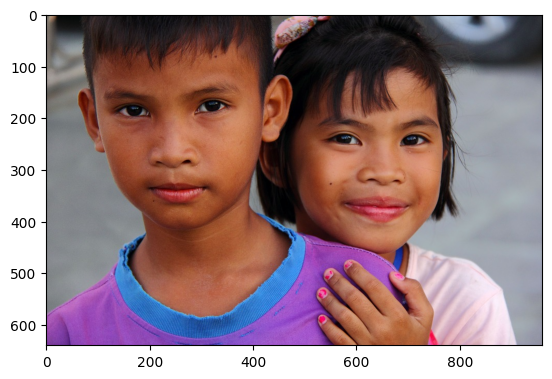

In [34]:
IMAGE_FILE = 'image.jpg'

import cv2
import pylab as plt

img = cv2.imread(IMAGE_FILE)
cv2_imshow(img)

In [35]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

In [37]:
detection_result

DetectionResult(detections=[Detection(bounding_box=BoundingBox(origin_x=95, origin_y=76, width=345, height=345), categories=[Category(index=0, score=0.9693185687065125, display_name=None, category_name=None)], keypoints=[NormalizedKeypoint(x=0.1823342889547348, y=0.2944765090942383, label='', score=0.0), NormalizedKeypoint(x=0.32925376296043396, y=0.2926965355873108, label='', score=0.0), NormalizedKeypoint(x=0.24390098452568054, y=0.4505675435066223, label='', score=0.0), NormalizedKeypoint(x=0.25363558530807495, y=0.5349926352500916, label='', score=0.0), NormalizedKeypoint(x=0.12993085384368896, y=0.3047645688056946, label='', score=0.0), NormalizedKeypoint(x=0.4366179406642914, y=0.29729342460632324, label='', score=0.0)]), Detection(bounding_box=BoundingBox(origin_x=461, origin_y=144, width=323, height=323), categories=[Category(index=0, score=0.9245200753211975, display_name=None, category_name=None)], keypoints=[NormalizedKeypoint(x=0.6159942150115967, y=0.37194395065307617, lab

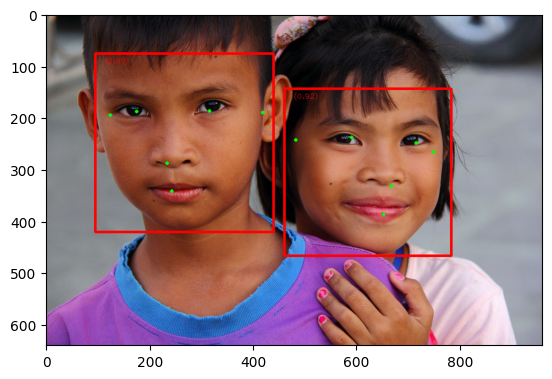

In [36]:
# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)

In [15]:
# onnx_pred[1]

In [42]:
[(i, n) for i, n in enumerate(model_proto.graph.node) if v[0] in str(n)]

[(6,
  input: "model_1/tf.math.subtract/Sub"
  input: "model_1/tf.math.reduce_mean_1/Mean"
  output: "model_1/tf.math.truediv_1/truediv"
  name: "model_1/tf.math.truediv_1/truediv"
  op_type: "Div"),
 (7,
  input: "model_1/tf.math.truediv_1/truediv"
  input: "const_fold_opt__862"
  output: "model_1/tf.__operators__.getitem_2/strided_slice2"
  name: "model_1/tf.__operators__.getitem_2/strided_slice2"
  op_type: "Reshape"),
 (9,
  input: "model_1/tf.__operators__.getitem_2/strided_slice3"
  input: "const_fold_opt__764"
  output: "model_1/GhumMarkerPoserMlpMixerGeneral/tf.math.truediv/truediv;model_1/GhumMarkerPoserMlpMixerGeneral/tf.math.truediv/truediv/y1"
  name: "model_1/GhumMarkerPoserMlpMixerGeneral/tf.math.truediv/truediv;model_1/GhumMarkerPoserMlpMixerGeneral/tf.math.truediv/truediv/y1"
  op_type: "Mul"),
 (10,
  input: "model_1/GhumMarkerPoserMlpMixerGeneral/tf.math.truediv/truediv;model_1/GhumMarkerPoserMlpMixerGeneral/tf.math.truediv/truediv/y1"
  input: "new_shape__872"
  outp

In [54]:
import onnx
from onnx import helper

modified_model = onnx.load(onnx_path)
intermediate_layer_value_info = helper.ValueInfoProto()
v = ['model_1/GhumMarkerPoserMlpMixerGeneral/MLPMixer/AddExtraTokens/concat']
intermediate_layer_value_info.name = v[0]
modified_model.graph.output.append(intermediate_layer_value_info)
# checker = onnx.checker.check_model(modified_model)
# tf2onnx.utils.save_onnx_model("./", "face_blendshapes", feed_dict={}, model_proto=model_proto)
modified_model_path = '/tmp/modified.onnx'
onnx.save(modified_model, modified_model_path)

m = rt.InferenceSession(modified_model_path, providers=providers)

outs = m.run(v,  {input_names[0]: x})
outs[0].shape

(1, 64, 1, 97)

In [56]:
message_length = 512

file = open('geometry_pipeline_metadata_landmarks.binarypb', 'rb')

eof = False
while not eof:

    data = file.read(message_length)
    eof = not data

    string = ''
    for i in range(0, len(data)):
        byte = data[i]
        if byte != '\xcc': # yuck!
            string += data[i]

    if not eof:
        foo_bar = FooBar()
        foo_bar.ParseFromString(string)

TypeError: can only concatenate str (not "int") to str

In [65]:
data[0]

10

In [57]:
data

b'\n\xea\x94\x01\x08\x00\x10\x00\x1d\x00\x00\x00\x00\x1d\x86\x02Z\xc0\x1d\x1fX\xbf@\x1d\xfc\xfc\xff>\x1dx\x0c\'?\x1d\x00\x00\x00\x00\x1d\x1d=\x90\xbf\x1d&8\xef@\x1d\xb4\x01\x00?\x1d\x1c(\x0c?\x1d\x00\x00\x00\x00\x1d\x92\xb2\x05\xc0\x1dS\xdd\xc1@\x1d\x98\xfc\xff>\x1d\r5\x1a?\x1d\xf9\x87\xed\xbe\x1dG\x92t?\x1dPF\xd4@\x1d\x84\xd7\xf6>\x1d;\xa7\xf1>\x1d\x00\x00\x00\x00\x1d\x9e$\xed\xbe\x1dC\xc5\xf2@\x1d\xe5\t\x00?\x1d\xb2\xf3\x06?\x1d\x00\x00\x00\x00\x1d\xf88\xbb>\x1d\x97\xc5\xe7@\x1d4\xf4\xff>\x1d\x04\x1b\xff>\x1d\x00\x00\x00\x00\x1d\xcfI\x1e@\x1do<\xb9@\x1d{\xc1\xff>\x1d\x00X\xcd>\x1d=\x19\x88\xc0\x1d\'\xf8$@\x1d\xa3\xe6Q@\x1d"U\x94>\x1d\x80\xf3\xc2>\x1d\x00\x00\x00\x00\x1d\xfe\x9b\x80@\x1d\xc9\x1c\xa9@\x1d\x1a\xfa\xff>\x1d\xa1\xf2\x9f>\x1d\x00\x00\x00\x00\x1d\xf1Y\x9c@\x1d\tT\xac@\x1dL\xfe\xff>\x1d\xd32\x8a>\x1d\x00\x00\x00\x00\x1d>0\x04A\x1d\xbch\x8f@\x1d\x82\x01\x00?\x1d\x08=\xdb=\x1d\x00\x00\x00\x00\x1dd<m\xc0\x1du\xad\xbb@\x1d\x82\x01\x00?\x1dP\x8e*?\x1d\x00\x00\x00\x00\x1dr\xc5z\xc